<a href="https://colab.research.google.com/github/rajashekar/colab/blob/main/wake_word_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install required modules
!pip install librosa textgrid torchsummary ffmpeg-python pocketsphinx fastprogress

In [ ]:
!pip install --upgrade google-cloud-texttospeech

  Attempting uninstall: google-auth
    Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2


In [ ]:
!pip install torchsummary

  Using cached torchsummary-1.5.1-py3-none-any.whl (2.8 kB)


In [ ]:
!conda install -c conda-forge -y ffmpeg

In [ ]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import soundfile

import torch
import torch.utils.data as tud
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torchaudio.transforms import MelSpectrogram, ComputeDeltas

from torch.optim.adamw import AdamW

import textgrid

import re
import json
import os
import math
import random

from pathlib import Path
from IPython.display import Audio

from tqdm import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
%matplotlib inline  

import pyaudio
import wave

from fastprogress import master_bar, progress_bar

from google.cloud import texttospeech

import warnings
warnings.simplefilter("ignore", UserWarning)

C:\Users\rajas\Anaconda3\lib\site-packages\torchaudio\extension\extension.py:13: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')


# 1. Prepare Dataset

## 1.1 load data from Mozilla common voice corpus

In [ ]:
common_voice_datapath = 'D:\\GoogleDrive\\datasets\\cv-corpus-6.1-2020-12-11\\en'

In [ ]:
%cd $common_voice_datapath

D:\GoogleDrive\datasets\cv-corpus-6.1-2020-12-11\en


In [ ]:
%ls

 Volume in drive D is Data
 Volume Serial Number is D2ED-5322

 Directory of D:\GoogleDrive\datasets\cv-corpus-6.1-2020-12-11\en

12/12/2020  06:54 PM    <DIR>          .
12/12/2020  06:54 PM    <DIR>          ..
07/13/2021  02:49 PM    <DIR>          clips
12/17/2020  05:05 PM         3,759,462 dev.tsv
12/17/2020  05:05 PM        44,843,183 invalidated.tsv
12/17/2020  05:05 PM        38,372,321 other.tsv
12/18/2020  01:32 PM           269,523 reported.tsv
12/17/2020  05:05 PM         3,633,900 test.tsv
12/17/2020  05:05 PM       138,386,852 train.tsv
12/17/2020  05:05 PM       285,317,674 validated.tsv
               7 File(s)    514,582,915 bytes
               3 Dir(s)  405,241,425,920 bytes free


In [ ]:
wake_words = ["hey", "fourth", "brain"]
wake_words_sequence = ["0", "1", "2"]
wake_word_seq_map = dict(zip(wake_words, wake_words_sequence))


In [ ]:
# Waves are repeated signals that oscillate 
# and vary in amplitude, depending on their complexity. In the real world,
# waves are continuous and mechanical — which is quite different from 
# computers being discrete and digital.

# So, how do we translate something continuous and mechanical into something that is
# discrete and digital? This is where the sample rate comes in. 
# Formally defined, the sample rate is the number of points per second 
# that is used to trace the signal.

# Say, for example, the sample rate of the recorded audio is 100. 
# This means that for every recorded second of audio, the computer will place 100 
# points along the signal in attempts to best “trace” the continuous curve. 
# Once all the points are in place, a smooth curve joins them all together 
# for humans to be able to visualize the sound. Since the recorded audio 
# is in terms of amplitude and time, we can intuitively say that the wave form
# operates in the time domain.

# Simply put, what resolution is to photos, sample rate is to audio.
sr = 16000

In [ ]:
train_data = pd.read_csv('train.tsv', sep='\t')
dev_data = pd.read_csv('dev.tsv', sep='\t')
test_data = pd.read_csv('test.tsv', sep='\t')

In [ ]:
print(f"Total clips available in Train {train_data.shape[0]}")
print(f"Total clips available in Dev {dev_data.shape[0]}")
print(f"Total clips available in Test {test_data.shape[0]}")

Total clips available in Train 564337
Total clips available in Dev 16164
Total clips available in Test 16164


In [ ]:
train_data.head()

,client_id,path,sentence,up_votes,down_votes,age,gender,accent,locale,segment
0,cb0a827ee9102c07033d21f1d4bbdf74701720bc8867d4...,common_voice_en_19731809.mp3,Hannu wrote of his expedition in stone.,3,0,NaN,NaN,NaN,en,NaN
1,cb0a827ee9102c07033d21f1d4bbdf74701720bc8867d4...,common_voice_en_19731810.mp3,Little India differs from many other neighbour...,3,1,NaN,NaN,NaN,en,NaN
2,cb0a827ee9102c07033d21f1d4bbdf74701720bc8867d4...,common_voice_en_19731811.mp3,Users had the ability to vote on the songs the...,2,0,NaN,NaN,NaN,en,NaN
3,cb0a827ee9102c07033d21f1d4bbdf74701720bc8867d4...,common_voice_en_19731812.mp3,"His major sponsor is Algario Communications, a...",2,1,NaN,NaN,NaN,en,NaN
4,cb118ddafaf4a59525bb7f8350549beb5f3d7720c8d83a...,common_voice_en_19968207.mp3,The mansion also has a marriage office.,2,0,NaN,NaN,NaN,en,NaN


## 1.2 Create postive dataset
Search for the clips that contains wake words

In [ ]:
regex_pattern = r'\b(?:{})\b'.format('|'.join(map(re.escape, wake_words)))
pattern = re.compile(regex_pattern, flags=re.IGNORECASE)
def wake_words_search(pattern, word):
  try:
    return bool(pattern.search(word))
  except TypeError:
    return False

In [ ]:
positive_train_data = train_data[[wake_words_search(pattern, sentence) for sentence in train_data['sentence']]]
positive_dev_data = dev_data[[wake_words_search(pattern, sentence) for sentence in dev_data['sentence']]]
positive_test_data = test_data[[wake_words_search(pattern, sentence) for sentence in test_data['sentence']]]

In [ ]:
positive_train_data.head()

,client_id,path,sentence,up_votes,down_votes,age,gender,accent,locale,segment
155,cda19cf7dfa99f5343e257e38fd818afbaeaed41fedc39...,common_voice_en_20433916.mp3,He was decorated with the Order of the Golden ...,2,0,NaN,NaN,NaN,en,NaN
200,ce43273edc7cdfe3c74d5529a590bfb53e18e296fe8c7a...,common_voice_en_20812859.mp3,The fourth candidate is awarded a two-year term.,2,0,NaN,NaN,NaN,en,NaN
876,da0850abc04765fb2d6cc79fb2c1a6aa337bf17bf114a8...,common_voice_en_20851643.mp3,The climax of the event is the fourth day of t...,2,0,NaN,NaN,NaN,en,NaN
1303,e1fbfbc8b55819ea8f6f7ca0ff0f4340773ee03089e8ee...,common_voice_en_18356188.mp3,A maddening joy pounded in his brain.,2,0,NaN,NaN,NaN,en,NaN
2241,f37a8a0eca2db577a30ae229433b6a5d04cd9cd8bf447a...,common_voice_en_23585349.mp3,"Where d'you live, hey?",2,0,NaN,NaN,NaN,en,NaN


In [ ]:
print(f"Total clips available in Train with wake words {positive_train_data.shape[0]}")
print(f"Total clips available in Dev with wake words {positive_dev_data.shape[0]}")
print(f"Total clips available in Test with wake words {positive_test_data.shape[0]}")

Total clips available in Train with wake words 1112
Total clips available in Dev with wake words 41
Total clips available in Test with wake words 31


In [ ]:
positive_train_data.iloc[0]

client_id     cda19cf7dfa99f5343e257e38fd818afbaeaed41fedc39...
path                               common_voice_en_20433916.mp3
sentence      He was decorated with the Order of the Golden ...
up_votes                                                      2
down_votes                                                    0
age                                                         NaN
gender                                                      NaN
accent                                                      NaN
locale                                                       en
segment                                                     NaN
Name: 155, dtype: object

## 1.3 Visualizing the data

### 1.3.1 loading mp3 file in librosa

In [ ]:
sounddata = librosa.core.load(f"{common_voice_datapath}/clips/common_voice_en_20433916.mp3", sr=sr, mono=True)[0]

### 1.3.2 Getting the length in milli seconds

In [ ]:
# calculate length
sounddata.size / sr * 1000

6384.0

In [ ]:
# getting the duration of the audio file
librosa.get_duration(sounddata, sr)

6.384

In [ ]:
sounddata.size

102144

### 1.3.3 Playing the audio sample

In [ ]:
Audio(sounddata,rate=sr)

### 1.3.4 Plotting the signal (Time domain)


Text(0, 0.5, 'Amplitude')

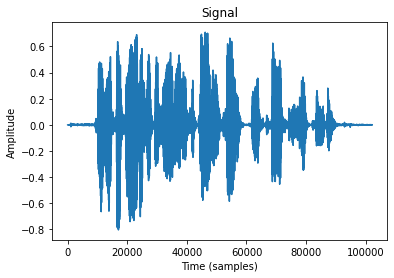

In [ ]:
# plotting the signal in time series
plt.plot(sounddata)
plt.title('Signal')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')

### 1.3.5 Calculate to FFT on one window segment

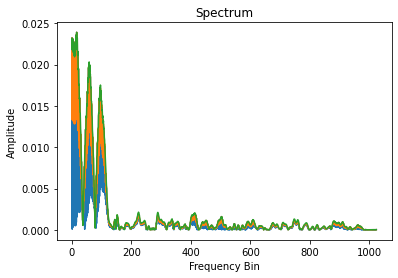

In [ ]:
# calculating FFT for one windowed segment
n_fft = 512
ft = np.abs(librosa.stft(sounddata[:n_fft], hop_length = 200))
plt.plot(ft);
plt.title('Spectrum');
plt.xlabel('Frequency Bin');
plt.ylabel('Amplitude');

### 1.3.6 Calculating Spectogram

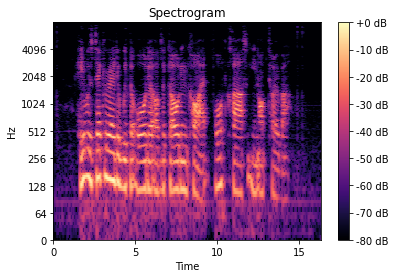

In [ ]:
# The FFT is computed on overlapping windowed segments of the signal, and we get what is called the spectrogram. 
# You can think of a spectrogram as a bunch of FFTs stacked on top of each other. It is a way to visually represent a signal’s loudness,
# or amplitude, as it varies over time at different frequencies.

# first compute short-time Fourier transform (STFT)
# The y-axis is converted to a log scale
spec = np.abs(librosa.stft(sounddata, hop_length=200))
# the color dimension is converted to decibels (you can think of this as the log scale of the amplitude)
spec = librosa.amplitude_to_db(spec, ref=np.max)

librosa.display.specshow(spec, sr=sr, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB');
plt.title('Spectrogram');

In [ ]:
spec.size

523775

### 1.3.7 Calculating Mel Spectogram

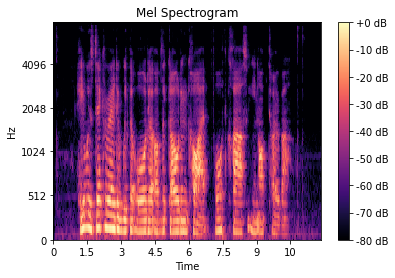

In [ ]:
# A mel spectrogram is a spectrogram where the frequencies are converted to the mel scale. 
mel_spect = librosa.feature.melspectrogram(y=sounddata, sr=sr, n_fft=512, hop_length=200)
mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
librosa.display.specshow(mel_spect, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram');
plt.colorbar(format='%+2.0f dB');

In [ ]:
mel_spect.size

65408

### 1.3.8 Trimming to fixed length
We will be using 750 ms

In [ ]:
# trimming to max length - 750 ms
max_len = 750 / 1000 * sr
max_len

12000.0

In [ ]:
Audio(sounddata[:int(max_len)], rate=sr)

In [ ]:
trim_sd =  sounddata[:int(max_len)]

In [ ]:
trim_sd.size

12000

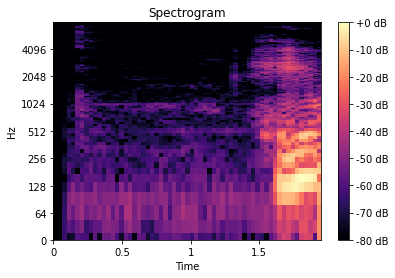

In [ ]:
spec = np.abs(librosa.stft(trim_sd, n_fft=512, hop_length=200))
# the color dimension is converted to decibels (you can think of this as the log scale of the amplitude)
spec = librosa.amplitude_to_db(spec, ref=np.max)

librosa.display.specshow(spec, sr=sr, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB');
plt.title('Spectrogram');

In [ ]:
spec.shape
# The number of rows in the STFT matrix D is (1 + n_fft/2)
# However, in speech processing, the recommended value is 512, corresponding to 23 milliseconds at a sample rate of 22050 Hz.
# The number of columns is size/hop_length + 1

(257, 61)

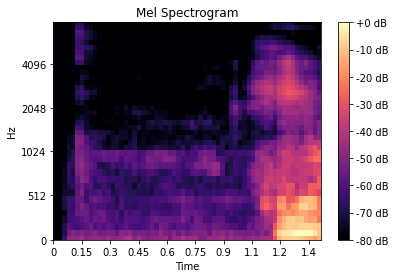

In [ ]:
# A mel spectrogram is a spectrogram where the frequencies are converted to the mel scale. 
# n_mels -  mel filters applied which reduces the number of bands to n_mels (typically 32-128)
mel_spect = librosa.feature.melspectrogram(y=trim_sd, sr=sr, n_mels=40, n_fft=512, hop_length=200)
mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
librosa.display.specshow(mel_spect, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram');
plt.colorbar(format='%+2.0f dB');

In [ ]:
mel_spect.shape

(40, 61)

 The sounds of our voices — are really just a sum of many sine and cosine signals.
<br> It is important to note that by using this transformation, we will be translating the audio from the time-domain to the frequency-domain.
<br> The time domain looks at the variation of the signal’s amplitude over time. This is useful for understanding its physical shape. 
<br> In order to plot this, we need time on the x-axis and amplitude on the y-axis. The shape gives us a good idea of how loud or quiet the sound will be.
<br> The frequency domain observes the constituent signals our recording is comprised of. By doing this, we can find a sort of “fingerprint” of the sound.
<br> In order to plot this, we need frequency on the x-axis and magnitude on the y-axis. 
<br> The larger the magnitude, the more important that frequency is. The magnitude is simply the absolute value of our results from the FFT.

<br> The Mel Scale is a logarithmic transformation of a signal’s frequency
<br> The linear audio spectrogram is ideally suited for applications where all frequencies have equal importance, 
<br> while mel spectrograms are better suited for applications that need to model human hearing perception.
<br> Mel spectrogram data is also suited for use in audio classification applications.

<br> The Fourier transform is a mathematical formula that allows us to decompose a signal 
<br> into it’s individual frequencies and the frequency’s amplitude. In other words, it 
<br> converts the signal from the time domain into the frequency domain. The result is called a spectrum.


<br>The y-axis is converted to a log scale, and the color dimension is converted to decibels  (you can think of this as the log scale of the amplitude). This is because humans can only  perceive a very small and concentrated range of frequencies and amplitudes.



<img src="https://miro.medium.com/max/600/1*uxQnCXu0qR1KeOOEZBq4-g.gif"/>

<img src="https://miro.medium.com/max/1400/1*xTYCtcx_7otHVu-uToI9dA.png"/>

<img src="https://miro.medium.com/max/1400/1*tIBRdtG3EfjmSIlraWVIxw.png"/>

## 1.4 Create Negative dataset

In [ ]:
negative_train_data = train_data[[not wake_words_search(pattern, sentence) for sentence in train_data['sentence']]]
negative_dev_data = dev_data[[not wake_words_search(pattern, sentence) for sentence in dev_data['sentence']]]
negative_test_data = test_data[[not wake_words_search(pattern, sentence) for sentence in test_data['sentence']]]

In [ ]:
negative_train_data.head()

,client_id,path,sentence,up_votes,down_votes,age,gender,accent,locale,segment
0,cb0a827ee9102c07033d21f1d4bbdf74701720bc8867d4...,common_voice_en_19731809.mp3,Hannu wrote of his expedition in stone.,3,0,NaN,NaN,NaN,en,NaN
1,cb0a827ee9102c07033d21f1d4bbdf74701720bc8867d4...,common_voice_en_19731810.mp3,Little India differs from many other neighbour...,3,1,NaN,NaN,NaN,en,NaN
2,cb0a827ee9102c07033d21f1d4bbdf74701720bc8867d4...,common_voice_en_19731811.mp3,Users had the ability to vote on the songs the...,2,0,NaN,NaN,NaN,en,NaN
3,cb0a827ee9102c07033d21f1d4bbdf74701720bc8867d4...,common_voice_en_19731812.mp3,"His major sponsor is Algario Communications, a...",2,1,NaN,NaN,NaN,en,NaN
4,cb118ddafaf4a59525bb7f8350549beb5f3d7720c8d83a...,common_voice_en_19968207.mp3,The mansion also has a marriage office.,2,0,NaN,NaN,NaN,en,NaN


In [ ]:
# negative data size
print(f"Total clips available in Train without wake words {negative_train_data.shape[0]}")
print(f"Total clips available in Dev without wake words {negative_dev_data.shape[0]}")
print(f"Total clips available in Test without wake words {negative_test_data.shape[0]}")

Total clips available in Train without wake words 563225
Total clips available in Dev without wake words 16123
Total clips available in Test without wake words 16133


In [ ]:
negative_data_percent = 1

negative_train_data = negative_train_data.sample(math.floor(negative_train_data.shape[0] * (negative_data_percent/100)))
negative_dev_data = negative_dev_data.sample(math.floor(negative_dev_data.shape[0] * (negative_data_percent/100)))
negative_test_data = negative_test_data.sample(math.floor(negative_test_data.shape[0] * (negative_data_percent/100)))

In [ ]:
# trimmed negative data sizes
print(f"Total clips available in Train without wake words {negative_train_data.shape[0]}")
print(f"Total clips available in Dev without wake words {negative_dev_data.shape[0]}")
print(f"Total clips available in Test without wake words {negative_test_data.shape[0]}")

Total clips available in Train without wake words 5632
Total clips available in Dev without wake words 161
Total clips available in Test without wake words 161


## 1.5 Using above prepare data for word alignment

In [ ]:
wake_word_datapath = 'D:\\GoogleDrive\\datasets\\hey-fourth-brain'
positive_data = "/positive/audio"
negative_data = "/negative/audio"

In [ ]:
Path(wake_word_datapath).mkdir(parents=True, exist_ok=True)

In [ ]:
# create postiive & negative dataset folder
Path(wake_word_datapath + positive_data).mkdir(parents=True, exist_ok=True)
Path(wake_word_datapath + negative_data).mkdir(parents=True, exist_ok=True)

In [ ]:
# save the dataframes we got from above in each dataset
positive_train_data[['path', 'sentence']].to_csv(wake_word_datapath + "/positive/train.csv", index=False)
positive_dev_data[['path', 'sentence']].to_csv(wake_word_datapath + "/positive/dev.csv", index=False)
positive_test_data[['path', 'sentence']].to_csv(wake_word_datapath + "/positive/test.csv", index=False)

negative_train_data[['path', 'sentence']].to_csv(wake_word_datapath  + "/negative/train.csv", index=False)
negative_dev_data[['path', 'sentence']].to_csv(wake_word_datapath  + "/negative/dev.csv", index=False)
negative_test_data[['path', 'sentence']].to_csv(wake_word_datapath  + "/negative/test.csv", index=False)

In [ ]:
def save_wav_lab(path, filename, sentence, decibels=40):
  # load file 
  sounddata = librosa.core.load(f"{common_voice_datapath}/clips/{filename}", sr=sr, mono=True)[0]
  # trim 
  sounddata = librosa.effects.trim(sounddata, top_db=decibels)[0]  
  # save as wav file
  soundfile.write(f"{wake_word_datapath}{path}/{filename.split('.')[0]}.wav", sounddata, sr)
  # write lab file
  with open(f"{wake_word_datapath}{path}/{filename.split('.')[0]}.lab", "w", encoding="utf-8") as f:
    f.write(sentence)

In [ ]:
positive_train_data.progress_apply(lambda x: save_wav_lab('/positive/audio', x['path'], x['sentence']), axis=1)
positive_dev_data.progress_apply(lambda x: save_wav_lab('/positive/audio', x['path'], x['sentence']), axis=1)
positive_test_data.progress_apply(lambda x: save_wav_lab('/positive/audio', x['path'], x['sentence']), axis=1)

In [ ]:
negative_train_data.progress_apply(lambda x: save_wav_lab(negative_data, x['path'], x['sentence']), axis=1)
negative_dev_data.progress_apply(lambda x: save_wav_lab(negative_data, x['path'], x['sentence']), axis=1)
negative_test_data.progress_apply(lambda x: save_wav_lab(negative_data, x['path'], x['sentence']), axis=1)

## 1.6 Do word alignment

In [ ]:
%cd $wake_word_datapath

D:\GoogleDrive\datasets\hey-fourth-brain


In [ ]:
aligned_data = "/aligned_data"
Path(wake_word_datapath + aligned_data).mkdir(parents=True, exist_ok=True)

In [ ]:
%%bash
wget https://github.com/MontrealCorpusTools/Montreal-Forced-Aligner/releases/download/v1.0.1/montreal-forced-aligner_win64.zip
unzip montreal-forced-aligner_win64.zip
rm -rf montreal-forced-aligner_win64.zip

In [ ]:
# downloading the dictionary 
%%bash
wget https://www.openslr.org/resources/11/librispeech-lexicon.txt

In [ ]:
# create aligned data for postive dataset
%%cmd
montreal-forced-aligner\bin\mfa_align -q positive\audio librispeech-lexicon.txt montreal-forced-aligner\pretrained_models\english.zip aligned_data

Microsoft Windows [Version 10.0.19041.1110]
(c) Microsoft Corporation. All rights reserved.

(base) D:\GoogleDrive\datasets\hey-fourth-brain>montreal-forced-aligner\bin\mfa_align -q positive\audio librispeech-lexicon.txt montreal-forced-aligner\pretrained_models\english.zip aligned_data
Setting up corpus information...
Number of speakers in corpus: 1, average number of utterances per speaker: 1184.0
Creating dictionary information...
Setting up training data...
Calculating MFCCs...
Calculating CMVN...
Number of speakers in corpus: 1, average number of utterances per speaker: 1184.0
Done with setup.
Done! Everything took 453.0202066898346 seconds

(base) D:\GoogleDrive\datasets\hey-fourth-brain>

100%|##########| 2/2 [02:30<00:00, 75.38s/it]


## 1.7 Get timestamps 

In [ ]:
def get_timestamps(path):
  filename = path.split('/')[-1].split('.')[0]
  filepath = f'aligned_data/audio/{filename}.TextGrid'
  words_timestamps = {}
  if os.path.exists(filepath):
    tg = textgrid.TextGrid.fromFile(filepath)
    for tg_intvl in range(len(tg[0])):
      word = tg[0][tg_intvl].mark
      if word:
        words_timestamps[word] = {'start': tg[0][tg_intvl].minTime, 'end':  tg[0][tg_intvl].maxTime}
  return words_timestamps

In [ ]:
def get_duration(path):
   sounddata = librosa.core.load(path, sr=sr, mono=True)[0]
   return sounddata.size / sr * 1000 # ms

In [ ]:
positive_train_data = pd.read_csv('positive/train.csv')
positive_dev_data = pd.read_csv('positive/dev.csv')
positive_test_data = pd.read_csv('positive/test.csv')

In [ ]:
positive_train_data['path'] = positive_train_data['path'].apply(lambda x: 'positive/audio/'+x.split('.')[0]+'.wav')
positive_dev_data['path'] = positive_dev_data['path'].apply(lambda x: 'positive/audio/'+x.split('.')[0]+'.wav')
positive_test_data['path'] = positive_test_data['path'].apply(lambda x: 'positive/audio/'+x.split('.')[0]+'.wav')

In [ ]:
positive_train_data['timestamps'] = positive_train_data['path'].progress_apply(get_timestamps)
positive_dev_data['timestamps'] = positive_dev_data['path'].progress_apply(get_timestamps)
positive_test_data['timestamps'] = positive_test_data['path'].progress_apply(get_timestamps)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 119.23it/s]


In [ ]:
positive_train_data['duration'] = positive_train_data['path'].progress_apply(get_duration)
positive_dev_data['duration'] = positive_dev_data['path'].progress_apply(get_duration)
positive_test_data['duration'] = positive_test_data['path'].progress_apply(get_duration)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 190.19it/s]


In [ ]:
positive_train_data.head()

,path,sentence,timestamps,duration
0,positive/audio/common_voice_en_20433916.wav,He was decorated with the Order of the Golden ...,"{'he': {'start': 0.0, 'end': 0.18}, 'was': {'s...",5152.0
1,positive/audio/common_voice_en_20812859.wav,The fourth candidate is awarded a two-year term.,"{'the': {'start': 0.0, 'end': 0.09}, 'fourth':...",3328.0
2,positive/audio/common_voice_en_20851643.wav,The climax of the event is the fourth day of t...,"{'the': {'start': 2.32, 'end': 2.41}, 'climax'...",3296.0
3,positive/audio/common_voice_en_18356188.wav,A maddening joy pounded in his brain.,"{'a': {'start': 0.26, 'end': 0.41}, 'maddening...",2592.0
4,positive/audio/common_voice_en_23585349.wav,"Where d'you live, hey?","{'where': {'start': 0.67, 'end': 0.92}, 'd'you...",1984.0


In [ ]:
negative_train_data = pd.read_csv('negative/train.csv')
negative_dev_data = pd.read_csv('negative/dev.csv')
negative_test_data = pd.read_csv('negative/test.csv')

In [ ]:
negative_train_data['path'] = negative_train_data['path'].apply(lambda x: 'negative/audio/'+x.split('.')[0]+'.wav')
negative_dev_data['path'] = negative_dev_data['path'].apply(lambda x: 'negative/audio/'+x.split('.')[0]+'.wav')
negative_test_data['path'] = negative_test_data['path'].apply(lambda x: 'negative/audio/'+x.split('.')[0]+'.wav')

In [ ]:
negative_train_data['timestamps'] = negative_train_data['path'].progress_apply(get_timestamps)
negative_dev_data['timestamps'] = negative_dev_data['path'].progress_apply(get_timestamps)
negative_test_data['timestamps'] = negative_test_data['path'].progress_apply(get_timestamps)

negative_train_data['duration'] = negative_train_data['path'].progress_apply(get_duration)
negative_dev_data['duration'] = negative_dev_data['path'].progress_apply(get_duration)
negative_test_data['duration'] = negative_test_data['path'].progress_apply(get_duration)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:00<00:00, 170.01it/s]


In [ ]:
negative_train_data.head()

,path,sentence,timestamps,duration
0,negative/audio/common_voice_en_19634294.wav,He was probably from Corfu and lived in Consta...,{},5024.0
1,negative/audio/common_voice_en_20083776.wav,Teia was killed and his brother Aligern surren...,{},5600.0
2,negative/audio/common_voice_en_20089676.wav,He is the most decorated ski racer from Norway.,{},3648.0
3,negative/audio/common_voice_en_21311845.wav,France and China provided most training to the...,{},4896.0
4,negative/audio/common_voice_en_20672291.wav,Both this painting and a small landscape were ...,{},4160.0


In [ ]:
# save above data
positive_train_data.to_csv(wake_word_datapath + "/positive/train.csv", index=False)
positive_dev_data.to_csv(wake_word_datapath + "/positive/dev.csv", index=False)
positive_test_data.to_csv(wake_word_datapath + "/positive/test.csv", index=False)

negative_train_data.to_csv(wake_word_datapath  + "/negative/train.csv", index=False)
negative_dev_data.to_csv(wake_word_datapath  + "/negative/dev.csv", index=False)
negative_test_data.to_csv(wake_word_datapath  + "/negative/test.csv", index=False)

# 2.  Load Dataset

In [ ]:
wake_word_datapath = 'D:\\GoogleDrive\\datasets\\hey-fourth-brain'

In [ ]:
%cd $wake_word_datapath

D:\GoogleDrive\datasets\hey-fourth-brain


In [ ]:
%ls

 Volume in drive D is Data
 Volume Serial Number is D2ED-5322

 Directory of D:\GoogleDrive\datasets\hey-fourth-brain

08/08/2021  09:20 AM    <DIR>          .
08/08/2021  09:20 AM    <DIR>          ..
07/27/2021  05:19 PM    <DIR>          aligned_data
08/05/2021  04:03 PM    <DIR>          generated
07/27/2021  06:43 PM       731,527,583 hey-fourth-brain.rar
10/03/2017  01:31 PM         5,627,653 librispeech-lexicon.txt
08/09/2021  08:14 AM           736,127 model_hey_fourth_brain.pt
04/05/2019  09:00 PM    <DIR>          montreal-forced-aligner
07/27/2021  03:04 PM    <DIR>          negative
08/07/2021  05:36 PM            24,044 output.wav
07/27/2021  03:04 PM    <DIR>          positive
07/28/2021  04:24 PM    <DIR>          valid-wake-words
08/08/2021  09:20 AM             1,415 zmuv.pt.bin
               5 File(s)    737,916,822 bytes
               8 Dir(s)  401,976,934,400 bytes free


In [ ]:
# Dataset checkpoint
positive_train_data = pd.read_csv(wake_word_datapath + '/positive/train.csv')
positive_dev_data = pd.read_csv(wake_word_datapath + '/positive/dev.csv')
positive_test_data = pd.read_csv(wake_word_datapath + '/positive/test.csv')

negative_train_data = pd.read_csv(wake_word_datapath + '/negative/train.csv')
negative_dev_data = pd.read_csv(wake_word_datapath + '/negative/dev.csv')
negative_test_data = pd.read_csv(wake_word_datapath + '/negative/test.csv')

In [ ]:
# max duration in positive dataset
print(f"Max duration in positive train {positive_train_data['duration'].max()}")
print(f"Min duration in positive train {positive_train_data['duration'].min()}")
print(f"Max duration in positive dev {positive_dev_data['duration'].max()}")
print(f"Min duration in positive dev {positive_dev_data['duration'].min()}")
print(f"Max duration in positive test {positive_test_data['duration'].max()}")
print(f"Min duration in positive test {positive_test_data['duration'].min()}")

Max duration in positive train 10560.0
Min duration in positive train 1504.0
Max duration in positive dev 9056.0
Min duration in positive dev 1600.0
Max duration in positive test 9432.0
Min duration in positive test 1248.0


In [ ]:
print(f"Max duration in negative train {negative_train_data['duration'].max()}")
print(f"Min duration in negative train {negative_train_data['duration'].min()}")
print(f"Max duration in negative dev {negative_dev_data['duration'].max()}")
print(f"Min duration in negative dev {negative_dev_data['duration'].min()}")
print(f"Max duration in negative test {negative_test_data['duration'].max()}")
print(f"Min duration in negative test {negative_test_data['duration'].min()}")

Max duration in negative train 14376.0
Min duration in negative train 896.0
Max duration in negative dev 9720.0
Min duration in negative dev 1216.0
Max duration in negative test 20512.0
Min duration in negative test 640.0


In [ ]:
train_ds = pd.concat([positive_train_data , negative_train_data]).sample(frac=1).reset_index(drop=True)
dev_ds = pd.concat([positive_dev_data , negative_dev_data]).sample(frac=1).reset_index(drop=True)
test_ds = pd.concat([positive_test_data , negative_test_data]).sample(frac=1).reset_index(drop=True)

In [ ]:
train_ds.shape

(6744, 4)

In [ ]:
print(f"Training dataset size {train_ds.shape}")
print(f"Validation dataset size {dev_ds.shape}")
print(f"Test dataset size {test_ds.shape}")

Training dataset size (6744, 4)
Validation dataset size (202, 4)
Test dataset size (192, 4)


In [ ]:
# checking pattern spread on train_ds
hey_pattern = re.compile(r'\bhey\b', flags=re.IGNORECASE)
fourth_pattern = re.compile(r'\bfourth\b', flags=re.IGNORECASE)
brain_pattern = re.compile(r'\bbrain\b', flags=re.IGNORECASE)

print(f"Total hey word {(train_ds[[wake_words_search(hey_pattern, sentence) for sentence in train_ds['sentence']]].size/train_ds.size) * 100} %")
print(f"Total fourth word {(train_ds[[wake_words_search(fourth_pattern, sentence) for sentence in train_ds['sentence']]].size/train_ds.size) * 100} %")
print(f"Total brain word {(train_ds[[wake_words_search(brain_pattern, sentence) for sentence in train_ds['sentence']]].size/train_ds.size) * 100} %")

Total hey word 0.9193357058125742 %
Total fourth word 11.728944246737841 %
Total brain word 3.855278766310795 %


## Generating Additional data using Google TTS

In [ ]:
%cd $wake_word_datapath

D:\GoogleDrive\datasets\hey-fourth-brain


In [ ]:
generated_data = 'generated'
Path(f"{wake_word_datapath}/{generated_data}").mkdir(parents=True, exist_ok=True)

In [ ]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="D:\\GoogleDrive\\Colab\\Fourth.Brain\\wake_word_detection\\first-project-319900-66c3486eaeba.json"

In [ ]:
from google.cloud import texttospeech
# Instantiates a client
client = texttospeech.TextToSpeechClient()

In [ ]:
import time
def generate_voices(word):
  Path(f"{wake_word_datapath}/{generated_data}/{word}").mkdir(parents=True, exist_ok=True)
  # Set the text input to be synthesized
  synthesis_input = texttospeech.SynthesisInput(text=word)
  # Performs the list voices request
  voices = client.list_voices()
  # Get english voices
  en_voices =  [voice.name for voice in voices.voices if voice.name.split("-")[0] == 'en']
  speaking_rates = np.arange(0.25, 4.25, 0.25).tolist()
  pitches = np.arange(-10.0, 10.0, 2).tolist() 
  file_count = 0
  start = time.time()

  for voi in en_voices:
    for sp_rate in speaking_rates:
      for pit in pitches:
        file_name = f'{wake_word_datapath}/{generated_data}/{word}/{voi}_{sp_rate}_{pit}.wav'
        voice = texttospeech.VoiceSelectionParams(language_code=voi[:5], name=voi)
        # Select the type of audio file you want returned
        audio_config = texttospeech.AudioConfig(
            # format of the audio byte stream.
            audio_encoding=texttospeech.AudioEncoding.LINEAR16,
        
            #Speaking rate/speed, in the range [0.25, 4.0]. 1.0 is the normal native speed
            speaking_rate=sp_rate,
        
            #Speaking pitch, in the range [-20.0, 20.0]. 20 means increase 20 semitones from the original pitch. -20 means decrease 20 semitones from the original pitch.
            pitch=pit # [-10, -5, 0, 5, 10]
        )
        response = client.synthesize_speech(
          request={"input": synthesis_input, "voice": voice, "audio_config": audio_config}
        )
        # The response's audio_content is binary.
        with open(file_name, "wb") as out:
            out.write(response.audio_content)
            file_count+=1
        if file_count%100 == 0:
          end = time.time()
          print(f"generated {file_count} files in {end-start} seconds")

In [ ]:
generate_voices(wake_words[0])

generated 100 files in 11.379350423812866 seconds
generated 200 files in 27.808510065078735 seconds
generated 300 files in 47.99334931373596 seconds
generated 400 files in 67.59245347976685 seconds
generated 500 files in 87.64888024330139 seconds
generated 600 files in 106.7192370891571 seconds
generated 700 files in 124.69506669044495 seconds
generated 800 files in 141.73996782302856 seconds
generated 900 files in 160.19320607185364 seconds
generated 1000 files in 177.92104291915894 seconds
generated 1100 files in 195.67321276664734 seconds
generated 1200 files in 213.30014038085938 seconds
generated 1300 files in 230.77677869796753 seconds
generated 1400 files in 248.4106764793396 seconds
generated 1500 files in 267.92716455459595 seconds
generated 1600 files in 287.4286587238312 seconds
generated 1700 files in 307.41148805618286 seconds
generated 1800 files in 327.60988426208496 seconds
generated 1900 files in 347.1212272644043 seconds
generated 2000 files in 367.17731261253357 seco

In [ ]:
generate_voices(wake_words[1])

generated 100 files in 14.005361318588257 seconds
generated 200 files in 37.05780220031738 seconds
generated 300 files in 56.96768665313721 seconds
generated 400 files in 77.58811354637146 seconds
generated 500 files in 99.65502309799194 seconds
generated 600 files in 121.57290625572205 seconds
generated 700 files in 140.7740180492401 seconds
generated 800 files in 157.9172396659851 seconds
generated 900 files in 175.7209460735321 seconds
generated 1000 files in 193.4350118637085 seconds
generated 1100 files in 210.5575225353241 seconds
generated 1200 files in 228.1162588596344 seconds
generated 1300 files in 245.69568824768066 seconds
generated 1400 files in 262.80717635154724 seconds
generated 1500 files in 283.0793128013611 seconds
generated 1600 files in 303.9854214191437 seconds
generated 1700 files in 325.745397567749 seconds
generated 1800 files in 348.7344081401825 seconds
generated 1900 files in 368.15623593330383 seconds
generated 2000 files in 388.6067759990692 seconds
gener

In [ ]:
generate_voices(wake_words[2])

generated 100 files in 20.32315468788147 seconds
generated 200 files in 41.35329270362854 seconds
generated 300 files in 61.08681678771973 seconds
generated 400 files in 83.31249952316284 seconds
generated 500 files in 103.35321617126465 seconds
generated 600 files in 123.97219705581665 seconds
generated 700 files in 143.85505294799805 seconds
generated 800 files in 161.3559193611145 seconds
generated 900 files in 180.31726622581482 seconds
generated 1000 files in 198.77269983291626 seconds
generated 1100 files in 216.66646885871887 seconds
generated 1200 files in 234.80779099464417 seconds
generated 1300 files in 253.60817074775696 seconds
generated 1400 files in 273.20765709877014 seconds
generated 1500 files in 293.3291931152344 seconds
generated 1600 files in 313.26748180389404 seconds
generated 1700 files in 334.13771963119507 seconds
generated 1800 files in 354.31155276298523 seconds
generated 1900 files in 374.5053234100342 seconds
generated 2000 files in 395.0197603702545 secon

In [ ]:
for word in wake_words:
  d = {}
  d['path'] = [f"{generated_data}/{word}/{file_name}" for file_name in os.listdir(f"{wake_word_datapath}/{generated_data}/{word}")]
  d['sentence'] = [word] * len(d['path'])
  pd.DataFrame(data=d).to_csv(f"{generated_data}/{word}.csv", index=False)

In [ ]:
word_cols = {'path' : [], 'sentence': []}
train, dev, test = pd.DataFrame(word_cols), pd.DataFrame(word_cols), pd.DataFrame(word_cols)
for word in wake_words:
  word_df = pd.read_csv(f"{generated_data}/{word}.csv")
  tra, val, te =  np.split(word_df.sample(frac=1, random_state=42),  [int(.6*len(word_df)), int(.8*len(word_df))])
  train = pd.concat([train , tra]).sample(frac=1).reset_index(drop=True)
  dev = pd.concat([dev , val]).sample(frac=1).reset_index(drop=True)
  test = pd.concat([test , te]).sample(frac=1).reset_index(drop=True)

train.to_csv(f"{generated_data}/train.csv", index=False)
dev.to_csv(f"{generated_data}/dev.csv", index=False)
test.to_csv(f"{generated_data}/test.csv", index=False)

In [ ]:
# add dummy values for these columns for generated data
train['timestamps'] = ''
train['duration'] = ''

dev['timestamps'] = ''
dev['duration'] = ''

test['timestamps'] = ''
test['duration'] = ''

## Combine Generated dataset

In [ ]:
train_ds = pd.concat([train_ds , train]).sample(frac=1).reset_index(drop=True)
dev_ds = pd.concat([dev_ds , dev]).sample(frac=1).reset_index(drop=True)
test_ds = pd.concat([test_ds , test]).sample(frac=1).reset_index(drop=True)

In [ ]:
train_ds.shape

(19992, 4)

In [ ]:
print(f"Training dataset size {train_ds.shape}")
print(f"Validation dataset size {dev_ds.shape}")
print(f"Test dataset size {test_ds.shape}")

Training dataset size (19992, 4)
Validation dataset size (4618, 4)
Test dataset size (4608, 4)


In [ ]:
# now verify how much data we have for train set
print(f"Total hey word {(train_ds[[wake_words_search(hey_pattern, sentence) for sentence in train_ds['sentence']]].size/train_ds.size) * 100} %")
print(f"Total fourth word {(train_ds[[wake_words_search(fourth_pattern, sentence) for sentence in train_ds['sentence']]].size/train_ds.size) * 100} %")
print(f"Total brain word {(train_ds[[wake_words_search(brain_pattern, sentence) for sentence in train_ds['sentence']]].size/train_ds.size) * 100} %")

Total hey word 22.398959583833534 %
Total fourth word 26.04541816726691 %
Total brain word 23.389355742296917 %


In [ ]:
key_pattern = re.compile("\'(?P<k>[^ ]+)\'")
def compute_labels(metadata, audio_data):
  label = len(wake_words) # by default negative label

  # if it is generated data then 
  if metadata['sentence'].lower() in wake_words:
    label = int(wake_word_seq_map[metadata['sentence'].lower()])
  else:
    # if the sentence has one wakeword get label and end timestamp
    for word in metadata['sentence'].lower().split():
      wake_word_found = False
      word = re.sub('\W+', '', word)
      if word in wake_words:
        wake_word_found = True
        break
  
    if wake_word_found:
      label = int(wake_word_seq_map[word])
      if word in  metadata['timestamps']:
        timestamps = metadata['timestamps']
        if type(timestamps) == str:
          timestamps = json.loads(key_pattern.sub(r'"\g<k>"', timestamps))
        word_ts = timestamps[word]
        audio_start_idx = int((word_ts['start'] * 1000) * sr / 1000)
        audio_end_idx = int((word_ts['end'] * 1000) * sr / 1000)
        audio_data = audio_data[audio_start_idx:audio_end_idx]
      else: # if there are issues with word alignment, we might not get ts
        label = len(wake_words)  # mark them for negative

  return label, audio_data

In [ ]:
def process_batch(batch):
  batch_tensor = {}
  window_size_ms = 750
  max_length = int(window_size_ms/1000 * sr)
  audio_tensors = []
  labels = []
  for sample in batch:
    # get audio_data in tensor format
    audio_data = librosa.core.load(sample['path'], sr=sr, mono=True)[0]
    # get the label and its audio
    label, audio_data = compute_labels(sample, audio_data)
    audio_data_length = audio_data.size / sr * 1000 #ms

    # below is to make sure that we always got length of 12000 
    # i.e 750 ms with sr 16000
    # trim to max_length
    if audio_data_length > window_size_ms:
      # randomly trim either at start and end
      if random.random() < 0.5:
        audio_data = audio_data[:max_length]
      else:
        audio_data = audio_data[audio_data.size-max_length:]

    # pad with zeros
    if audio_data_length < window_size_ms:
      # randomly either append or prepend
      if random.random() < 0.5:
        audio_data = np.append(audio_data, np.zeros(int(max_length - audio_data.size)))
      else:
        audio_data = np.append(np.zeros(int(max_length - audio_data.size)), audio_data)

    audio_tensors.append(torch.from_numpy(audio_data))
    labels.append(label)

  batch_tensor = {
      'audio': torch.stack(audio_tensors),
      'labels': torch.tensor(labels) 
  }
  
  return batch_tensor

In [ ]:
batch_size = 16
num_workers = 0

train_dl = tud.DataLoader(train_ds.to_dict(orient='records'),
                  batch_size=batch_size,
                  drop_last=True,
                  shuffle=True,
                  num_workers=num_workers,
                  collate_fn=process_batch)

dev_dl = tud.DataLoader(dev_ds.to_dict(orient='records'),
                  batch_size=batch_size,
                  num_workers=num_workers,
                  collate_fn=process_batch)

test_dl = tud.DataLoader(test_ds.to_dict(orient='records'),
                  batch_size=batch_size,
                  num_workers=num_workers,
                  collate_fn=process_batch)

zmuv_dl = tud.DataLoader(train_ds.to_dict(orient='records'),
                  batch_size=1,
                  num_workers=num_workers,
                  collate_fn=process_batch)

# 3. Model Architecture

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_labels, num_maps1, num_maps2, num_hidden_input, hidden_size):
        super(CNN, self).__init__()
        conv0 = nn.Conv2d(1, num_maps1, (8, 16), padding=(4, 0), stride=(2, 2), bias=True)
        pool = nn.MaxPool2d(2)
        conv1 = nn.Conv2d(num_maps1, num_maps2, (5, 5), padding=2, stride=(2, 1), bias=True)
        self.encoder1 = nn.Sequential(conv0,
                                      nn.ReLU(),
                                      pool,
                                      nn.BatchNorm2d(num_maps1, affine=True))
        self.encoder2 = nn.Sequential(conv1,
                                      nn.ReLU(),
                                      pool,
                                      nn.BatchNorm2d(num_maps2, affine=True))
        self.output = nn.Sequential(nn.Linear(num_hidden_input, hidden_size),
                                    nn.ReLU(),
                                    nn.Dropout(0.1),
                                    nn.Linear(hidden_size, num_labels))

    def forward(self, x):
        x = x[:, :1] # log_mels only
        x = x.permute(0, 1, 3, 2)  # (time, n_mels)
        # pass through first conv layer
        x1 = self.encoder1(x)
        # pass through second conv layer
        x2 = self.encoder2(x1)
        # flattening - keep first dim batch same, flatten last 3 dims
        x2 = x2.view(x2.size(0), x2.size(1), -1)
        x = x2.view(x2.size(0), -1)
        return self.output(x)

In [ ]:
class CNN_Cal(nn.Module):
    def __init__(self, num_labels, num_maps1, num_maps2, num_hidden_input, hidden_size):
        super(CNN_Cal, self).__init__()
        conv0 = nn.Conv2d(1, num_maps1, (8, 16), padding=(4, 0), stride=(2, 2), bias=True)
        pool = nn.MaxPool2d(2)
        conv1 = nn.Conv2d(num_maps1, num_maps2, (5, 5), padding=2, stride=(2, 1), bias=True)
        self.encoder1 = nn.Sequential(conv0,
                                      nn.ReLU(),
                                      pool,
                                      nn.BatchNorm2d(num_maps1, affine=True))
        self.encoder2 = nn.Sequential(conv1,
                                      nn.ReLU(),
                                      pool,
                                      nn.BatchNorm2d(num_maps2, affine=True))

    def forward(self, x):
        x = x[:, :1] # log_mels only
        x = x.permute(0, 1, 3, 2)  # change to (time, n_mels)
        # pass through first conv layer
        x1 = self.encoder1(x)
        # pass through second conv layer
        x2 = self.encoder2(x1)
        # flattening - keep first dim batch same, flatten last 3 dims
        x = x2.view(x2.size(0), -1)
        return x

In [ ]:
num_labels = len(wake_words) + 1 # oov
num_maps1  = 48
num_maps2  = 64
num_hidden_input =  768
hidden_size = 128
model = CNN(num_labels, num_maps1, num_maps2, num_hidden_input, hidden_size)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
model

CNN(
  (encoder1): Sequential(
    (0): Conv2d(1, 48, kernel_size=(8, 16), stride=(2, 2), padding=(4, 0))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (encoder2): Sequential(
    (0): Conv2d(48, 64, kernel_size=(5, 5), stride=(2, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (output): Sequential(
    (0): Linear(in_features=768, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=4, bias=True)
  )
)

In [ ]:
num_labels = len(wake_words) + 1 # oov
num_maps1  = 48
num_maps2  = 64
num_hidden_input =  768
hidden_size = 128
model_calc = CNN_Cal(num_labels, num_maps1, num_maps2, num_hidden_input, hidden_size)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_calc.to(device)
model_calc

CNN_Cal(
  (encoder1): Sequential(
    (0): Conv2d(1, 48, kernel_size=(8, 16), stride=(2, 2), padding=(4, 0))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (encoder2): Sequential(
    (0): Conv2d(48, 64, kernel_size=(5, 5), stride=(2, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [ ]:
summary(model_calc, input_size=(1,80,61))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 48, 31, 33]           6,192
              ReLU-2           [-1, 48, 31, 33]               0
         MaxPool2d-3           [-1, 48, 15, 16]               0
         MaxPool2d-4           [-1, 48, 15, 16]               0
       BatchNorm2d-5           [-1, 48, 15, 16]              96
            Conv2d-6            [-1, 64, 8, 16]          76,864
              ReLU-7            [-1, 64, 8, 16]               0
         MaxPool2d-8             [-1, 64, 4, 8]               0
         MaxPool2d-9             [-1, 64, 4, 8]               0
      BatchNorm2d-10             [-1, 64, 4, 8]             128
Total params: 83,280
Trainable params: 83,280
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 1.18
Params size (MB): 0.32
Estimated Tot

In [ ]:
summary(model, input_size=(1,40,61))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 48, 31, 13]           6,192
              ReLU-2           [-1, 48, 31, 13]               0
         MaxPool2d-3            [-1, 48, 15, 6]               0
         MaxPool2d-4            [-1, 48, 15, 6]               0
       BatchNorm2d-5            [-1, 48, 15, 6]              96
            Conv2d-6             [-1, 64, 8, 6]          76,864
              ReLU-7             [-1, 64, 8, 6]               0
         MaxPool2d-8             [-1, 64, 4, 3]               0
         MaxPool2d-9             [-1, 64, 4, 3]               0
      BatchNorm2d-10             [-1, 64, 4, 3]             128
           Linear-11                  [-1, 128]          98,432
             ReLU-12                  [-1, 128]               0
          Dropout-13                  [-1, 128]               0
           Linear-14                   

## Calculate Zero Mean Unite Variance (zmuv)

In [ ]:
from typing import Iterable
class ZmuvTransform(nn.Module):
    def __init__(self):
        super().__init__()
        self.register_buffer('total', torch.zeros(1))
        self.register_buffer('mean', torch.zeros(1))
        self.register_buffer('mean2', torch.zeros(1))

    def update(self, data, mask=None):
        with torch.no_grad():
            if mask is not None:
                data = data * mask
                mask_size = mask.sum().item()
            else:
                mask_size = data.numel()
            self.mean = (data.sum() + self.mean * self.total) / (self.total + mask_size)
            self.mean2 = ((data ** 2).sum() + self.mean2 * self.total) / (self.total + mask_size)
            self.total += mask_size

    def initialize(self, iterable: Iterable[torch.Tensor]):
        for ex in iterable:
            self.update(ex)

    @property
    def std(self):
        return (self.mean2 - self.mean ** 2).sqrt()

    def forward(self, x):
        return (x - self.mean) / self.std

In [ ]:
zmuv_transform = ZmuvTransform().to(device)
if Path("zmuv.pt.bin").exists():
    zmuv_transform.load_state_dict(torch.load(str("zmuv.pt.bin")))
else:
  for idx, batch in enumerate(tqdm(zmuv_dl, desc="Constructing ZMUV")):
    zmuv_transform.update(batch['audio'].to(device))
  print(dict(zmuv_mean=zmuv_transform.mean, zmuv_std=zmuv_transform.std))
  torch.save(zmuv_transform.state_dict(), str("zmuv.pt.bin"))

In [ ]:
learning_rate = 0.001
weight_decay = 0.0
lr_decay = 0.75

criterion = nn.CrossEntropyLoss()
params = list(filter(lambda x: x.requires_grad, model.parameters()))
optimizer = AdamW(params, learning_rate, weight_decay=weight_decay)

In [ ]:
num_mels = 40 # https://en.wikipedia.org/wiki/Mel_scale
num_fft = 512 # window length - Fast Fourier Transform
hop_length = 200  # making hops of size hop_length each time to sample the next window
def audio_transform(audio_data):
  # Transformations
  # Mel-scale spectrogram is a combination of Spectrogram and mel scale conversion
  # 1. compute FFT - for each window to transform from time domain to frequency domain
  # 2. Generate Mel Scale - Take entire freq spectrum & seperate to n_mels evenly spaced
  #    frequencies. (not by distance on freq domain but distance as it is heard by human ear)
  # 3. Generate Spectrogram - For each window, decompose the magnitude of the signal
  #    into its components, corresponding to the frequencies in the mel scale. 
  mel_spectrogram  = MelSpectrogram(n_mels=num_mels,
                                    sample_rate=sr,
                                    n_fft=num_fft,
                                    hop_length=hop_length)
  mel_spectrogram.to(device)
  log_mels = mel_spectrogram(audio_data.float()).add_(1e-7).log_().contiguous()
  # returns (channel, n_mels, time) 

  compute_deltas = ComputeDeltas()

  #Compute delta coefficients of a tensor, usually a spectrogram.
  #Tensor of deltas of dimension (…, freq, time).
  deltas = compute_deltas(log_mels)
  accels = compute_deltas(deltas)
  return torch.stack((log_mels, deltas, accels), 1).to(device)


# 4. Training

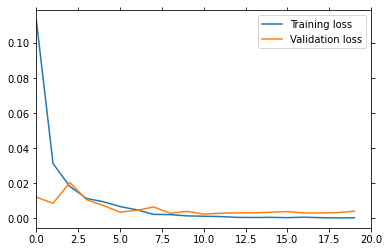

C:\Users\rajas\Anaconda3\lib\site-packages\numpy\core\_asarray.py:171: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return array(a, dtype, copy=False, order=order, subok=True)


In [ ]:
epochs = 20

# config for progress bar
mb = master_bar(range(epochs))
mb.names = ['Training loss', 'Validation loss']
x = []

training_losses = []
validation_losses = []

for epoch in mb:
  x.append(epoch)
  # Evaluate
  model.train()
  total_loss = torch.Tensor([0.0]).to(device)
  #pbar = tqdm(train_dl, total=len(train_dl), position=0, desc="Training", leave=True)
  for batch in progress_bar(train_dl, parent=mb):
    audio_data = batch['audio'].to(device)
    labels = batch['labels'].to(device)
    # get mel spectograms
    mel_audio_data = audio_transform(audio_data)
    # do zmuv transform
    mel_audio_data = zmuv_transform(mel_audio_data)
    predicted_scores = model(mel_audio_data)
    # get loss
    loss = criterion(predicted_scores, labels)

    optimizer.zero_grad()
    model.zero_grad()

    # backward propagation
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        total_loss += loss
      
  for group in optimizer.param_groups:
    group["lr"] *= lr_decay

  mean = total_loss / len(train_dl)
  training_losses.append(mean.cpu())
  
  # Evaluate  
  model.eval()
  validation_loss = torch.Tensor([0.0]).to(device)
  with torch.no_grad():
    #pbar = tqdm(dev_dl, total=len(dev_dl), position=0, desc="Evaluating", leave=True)
    for batch in progress_bar(dev_dl, parent=mb):
      audio_data = batch['audio'].to(device)
      labels = batch['labels'].to(device)
      # get mel spectograms
      mel_audio_data = audio_transform(audio_data)
      # do zmuv transform
      mel_audio_data = zmuv_transform(mel_audio_data)
      predicted_scores = model(mel_audio_data)
      # get loss
      loss = criterion(predicted_scores, labels)
      validation_loss += loss

  val_mean = validation_loss / len(dev_dl)
  validation_losses.append(val_mean.cpu())

  # Update training chart
  mb.update_graph([[x, training_losses], [x, validation_losses]], [0,epochs])
  mb.write(f"\nEpoch {epoch}: Training loss {mean.item()} validation loss {val_mean.item()} with lr {group['lr']}")

In [ ]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


## Save Model

In [ ]:
torch.save(model.state_dict(), 'model_hey_fourth_brain.pt')

# Evaluate on Test set

Testing: 100%|█████████████████████████████████████████████████████████████████████████████| 288/288 [01:15<00:00,  3.82it/s]
C:\Users\rajas\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass display_labels=['hey', 'fourth', 'brain', 'oov'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


              precision    recall  f1-score   support

       brain       1.00      1.00      1.00      1478
      fourth       1.00      1.00      1.00      1485
         hey       1.00      1.00      1.00      1483
         oov       0.99      1.00      1.00       162

    accuracy                           1.00      4608
   macro avg       1.00      1.00      1.00      4608
weighted avg       1.00      1.00      1.00      4608

Test Loss: 0.010065

Test Accuracy of   hey: 99% (1480/1483)
Test Accuracy of fourth: 99% (1484/1485)
Test Accuracy of brain: 100% (1478/1478)
Test Accuracy of   oov: 100% (162/162)

Test Accuracy (Overall): 99% (4604/4608)


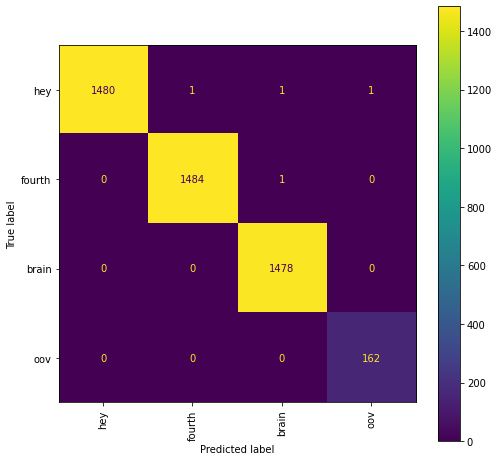

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# track test loss
test_loss = 0.0
classes = wake_words[:]
# oov
classes.append("oov")
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))

actual = []
predictions = []

model.eval()
# iterate over test data
pbar = tqdm(test_dl, total=len(test_dl), position=0, desc="Testing", leave=True)
for batch in pbar:
    # move tensors to GPU if CUDA is available
    audio_data = batch['audio'].to(device)
    labels = batch['labels'].to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    mel_audio_data = audio_transform(audio_data)
    # do zmuv transform
    mel_audio_data = zmuv_transform(mel_audio_data)
    output = model(mel_audio_data)
    # calculate the batch loss
    loss = criterion(output, labels)
    # update test loss 
    test_loss += loss.item()*audio_data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(labels.shape[0]):
        label = labels.data[i]
        class_correct[label.long()] += correct[i].item()
        class_total[label.long()] += 1
        # for confusion matrix    
        actual.append(classes[labels.data[i].long().item()])
        predictions.append(classes[pred.data[i].item()])
        
# plot confusion matrix
cm = confusion_matrix(actual, predictions, labels=classes)
print(classification_report(actual, predictions))
cmp = ConfusionMatrixDisplay(cm, classes)
fig, ax = plt.subplots(figsize=(8,8))
cmp.plot(ax=ax, xticks_rotation='vertical')


# average test loss
test_loss = test_loss/len(test_ds)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

In [ ]:
%pwd

'D:\\GoogleDrive\\datasets\\hey-fourth-brain'

In [ ]:
CHUNK = 500
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = sr
RECORD_MILLI_SECONDS = 750
WAVE_OUTPUT_FILENAME = "output.wav"

p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK)

print("* recording")

frames = []

for i in range(0, int(RATE / CHUNK * RECORD_MILLI_SECONDS/1000)):
    data = stream.read(CHUNK)
    frames.append(data)

print("* done recording")

stream.stop_stream()
stream.close()
p.terminate()

wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()

* recording
* done recording


In [ ]:
WAVE_OUTPUT_FILENAME='generated/brain/en-AU-Standard-A_1.0_2.0.wav'

In [ ]:
sounddata = librosa.core.load(WAVE_OUTPUT_FILENAME, sr=sr, mono=True)[0]

In [ ]:
Audio(sounddata, rate=sr)

In [ ]:
  window_size_ms = 750
  max_length = int(window_size_ms/1000 * sr)
  audio_data_length = sounddata.size / sr * 1000 #m

  # pad with zeros
  if audio_data_length < window_size_ms:
    # randomly either append or prepend
    if random.random() < 0.5:
      sounddata = np.append(sounddata, np.zeros(int(max_length - sounddata.size)))
    else:
      sounddata = np.append(np.zeros(int(max_length - sounddata.size)), sounddata)

In [ ]:
# get duration 
# calculate length
sounddata_length = sounddata.size / sr * 1000

In [ ]:
sounddata.size

12000

In [ ]:
sounddata_length

750.0

In [ ]:
inp = torch.from_numpy(sounddata).float().to(device)

In [ ]:
inp.size()

torch.Size([12000])

In [ ]:
delta_ms = int(inp.size(-1) / sr * 1000)

In [ ]:
delta_ms

750

In [ ]:
mel_audio_data = audio_transform(inp.unsqueeze(0))

In [ ]:
mel_audio_data.size()

torch.Size([1, 3, 40, 61])

In [ ]:
model.eval()
scores = model(mel_audio_data)

In [ ]:
scores

tensor([[ -9.2291,   3.4615, -19.2211,   3.8502]], device='cuda:0',
       grad_fn=<AddmmBackward>)

In [ ]:
scores = F.softmax(scores, -1).squeeze(1)  # [num_frames x num_labels]

In [ ]:
scores[0]

tensor([1.2443e-06, 4.0403e-01, 5.6949e-11, 5.9597e-01], device='cuda:0',
       grad_fn=<SelectBackward>)

In [ ]:
preds = scores[0].cpu().detach().numpy()
preds = preds / preds.sum()

array([1.2442987e-06, 4.0402707e-01, 5.6948911e-11, 5.9597164e-01],
      dtype=float32)

In [ ]:
print([f"{x:.3f}" for x in preds.tolist()])
print(f"predicted label {np.argmax(preds)} - {classes[np.argmax(preds)]}")

['0.000', '0.404', '0.000', '0.596']
predicted label 3 - oov


In [ ]:
from pocketsphinx import AudioFile

config = {
    'verbose': False,
    'audio_file': WAVE_OUTPUT_FILENAME,
    'keyphrase': "<sil>",
    'kws_threshold': 1e-20,
    'lm': False
}

audio = AudioFile(**config)
for phrase in audio:
    print(phrase.segments(detailed=True))
    result = phrase.segments(detailed=True)
    if len(result) == 1:
      start_time = result[0][2] * 10
      end_time = result[0][3] * 10
      print('%4sms ~ %4sms' % (start_time, end_time))

# Stream Inference

In [ ]:
model.load_state_dict(torch.load('model_hey_fourth_brain.pt'))

<All keys matched successfully>

In [ ]:
WAVE_OUTPUT_FILENAME = "output.wav"
def sav_temp_wav(frames):
  wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
  wf.setnchannels(CHANNELS)
  wf.setsampwidth(p.get_sample_size(FORMAT))
  wf.setframerate(RATE)
  wf.writeframes(b''.join(frames))
  wf.close()

In [ ]:
import itertools
import time

audio_buf = []
audio_buf_len = 16
audio_float_size = 32767

RATE = sr
CHUNK = 500
FORMAT = pyaudio.paInt16
CHANNELS = 1

curr_time = time.time
pred_history = []
label_history = []

smoothing_window_ms = 50.0
inference_window_ms = 2000.0
tolerance_window_ms = 500.0

def on_audio(in_data, frame_count, time_info, status):
  data = (in_data, pyaudio.paContinue)
  try:
    audio_buf.append(in_data)
    if len(audio_buf) != audio_buf_len:
      return data
    
    audio_data = np.frombuffer(b''.join(audio_buf), dtype=np.int16).astype(np.float) / audio_float_size
    audio_data = torch.from_numpy(audio_data).float().to(device)
    delta_ms = int(audio_data.size(-1) / RATE * 1000)
  
    mel_audio_data = audio_transform(audio_data.unsqueeze(0))
    mel_audio_data = zmuv_transform(mel_audio_data)
    print(mel_audio_data.shape)
  
    scores = model(mel_audio_data)
    scores = F.softmax(scores, -1).squeeze(1)  # [num_frames x num_labels]
  
    sequence_present = False
    delta_ms /= len(scores)
  
    for frame in scores:
      p = frame.cpu().numpy()
      p = p / p.sum()
      print([f"{x:.3f}" for x in p.tolist()], np.argmax(p))
  
      curr_time += delta_ms
      pred_history.append((curr_time, p))
  
      pred_history = list(itertools.dropwhile(lambda x: curr_time - x[0] > smoothing_window_ms, pred_history))
      lattice = np.vstack([t for _, t in pred_history])
      lattice_max = np.max(lattice, 0)
      max_label = lattice_max.argmax()
      max_prob = lattice_max[max_label]
      label_history.append((curr_time, p))
  
      label_history = list(itertools.dropwhile(lambda x: curr_time - x[0] > inference_window_ms, label_history))
  
      curr_label = None
      target_state = 0
      last_valid_timestamp = 0
  
      for history in label_history:
        curr_timestamp, label = history
        target_label = wake_words[target_state]
        if label == target_label:
          target_state += 1
          if target_state == len(wake_words):
            sequence_present = True
            break
          curr_label = wake_words[target_state - 1]
          last_valid_timestamp = curr_timestamp
        elif label == curr_label:
          last_valid_timestamp = curr_timestamp
        elif last_valid_timestamp + tolerance_window_ms < curr_timestamp:
          # out of tolerance window, start from first 
          curr_label = None
          target_state = 0
          last_valid_timestamp = 0
      
      if sequence_present:
        print("SEQUENCE DETECTED")
        break
  except Exception as e:
    print(e)
  return data

In [ ]:
model.eval()
audio_float_size = 32767
p = pyaudio.PyAudio()
    
stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK,
                stream_callback=on_audio)

stream.start_stream()
while stream.is_active():
    time.sleep(0.1)

In [ ]:
stream.stop_stream()
stream.close()
p.terminate()

In [ ]:
model.eval()

classes = wake_words[:]
# oov
classes.append("oov")

audio_float_size = 32767
p = pyaudio.PyAudio()

CHUNK = 500
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = sr
RECORD_MILLI_SECONDS = 750

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK)

print("* listening .. ")

inference_track = []
target_state = 0

while True:
  no_of_frames = 4
  
  #import pdb;pdb.set_trace()
  batch = []
  for frame in range(no_of_frames):
    frames = []
    for i in range(0, int(RATE / CHUNK * RECORD_MILLI_SECONDS/1000)):
        data = stream.read(CHUNK)
        frames.append(data)
    audio_data = np.frombuffer( b''.join(frames), dtype=np.int16).astype(np.float) / audio_float_size
    inp = torch.from_numpy(audio_data).float().to(device)
    batch.append(inp)

  audio_tensors = torch.stack(batch)

  #sav_temp_wav(frames)
  mel_audio_data = audio_transform(audio_tensors)
  mel_audio_data = zmuv_transform(mel_audio_data)
  scores = model(mel_audio_data)
  scores = F.softmax(scores, -1).squeeze(1)  # [no_of_frames x num_labels]
  #import pdb;pdb.set_trace()
  for score in scores:
    preds = score.cpu().detach().numpy()
    preds = preds / preds.sum()
    # print([f"{x:.3f}" for x in preds.tolist()])
    pred_idx = np.argmax(preds)
    pred_word = classes[pred_idx]
    #print(f"predicted label {pred_idx} - {pred_word}")
    label = wake_words[target_state]
    if pred_word == label:
      target_state += 1 # go to next label
      inference_track.append(pred_word)
      print(inference_track)
      if inference_track == wake_words:
        print(f"Wake word {' '.join(inference_track)} detected")
        target_state = 0
        inference_track = []
        break

* listening .. 


C:\Users\rajas\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


['hey']
['hey', 'fourth']
['hey', 'fourth', 'brain']
Wake word hey fourth brain detected


KeyboardInterrupt: ignored